In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
df_labels = pd.read_csv('../data/label_names.csv')
train_imgs = pkl.load(open('../data/train.pickle', 'rb'))
test_imgs = pkl.load(open('../data/test.pickle', 'rb'))
valid_imgs = pkl.load(open('../data/valid.pickle', 'rb'))
labels = pkl.load(open('../data/labels.pickle', 'rb'))

In [3]:
labels_dict = dict(zip(list(df_labels.ClassId), list(df_labels.SignName)))
print(labels_dict)

{0: 'Speed Limit (20km/h)', 1: 'Speed Limit (30km/h)', 2: 'Speed Limit (50km/h)', 3: 'Speed Limit (60km/h)', 4: 'Speed Limit (70km/h)', 5: 'Speed Limit (80km/h)', 6: 'Конец ограничения скорости(80km/h)', 7: 'Ограничение скорости (100km/h)', 8: 'Ограничение скорости (120km/h)', 9: 'Обгон запрещен', 10: 'Обгон грузовым автомобилем запрещен', 11: 'Right-of-way at the next intersection', 12: 'Главная дорога', 13: 'Уступите дорогу', 14: 'Стоп', 15: 'Движение запрещено', 16: 'Движение грузовых автомобилей запрещено', 17: 'Въезд запрещен', 18: 'Прочие опасности', 19: 'Опасный поворот налево', 20: 'Опасный поворот направо', 21: 'Опасные повороты', 22: 'Неровная дорога', 23: 'Скользкая дорога', 24: 'Сужение дороги', 25: 'Дорожные работы', 26: 'Светофорное регулирование', 27: 'Пешеходный переход', 28: 'Дети', 29: 'Пересечение с велосипедной дорожкой', 30: 'Снег\\гололед', 31: 'Дикие животные', 32: 'Конец зоны всех ограничений', 33: 'Движение направо', 34: 'Движение налево', 35: 'Движение прямо',

In [4]:
X_train = train_imgs['features']
Y_train = train_imgs['labels']

X_val = valid_imgs['features']
Y_val = valid_imgs['labels']

X_test = test_imgs['features']
Y_test = test_imgs['labels']


In [ ]:
def shapes(X, Y):
    print('X: ', X.shape)
    print('Y: ', Y.shape)
shapes(X_train, Y_train)
shapes(X_val, Y_val)
shapes(X_test, Y_test)

In [ ]:
fig, ax = plt.subplots(3)
ax[0].imshow(X_train[0])
ax[1].imshow(X_val[20])
ax[2].imshow(X_test[3])

In [ ]:
# Определение модели и ее типа - Секвентальная см линейным стеком слоев.
model = Sequential([
    # Шаг №1 - Слой свертки. Форма на вход: 32х32х3, где 3 - количетсво каналов (RGB).
    Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'),
    # Шаг №2 - Слой подвыборки с извлечением максимума. Размеры матрицы: 2х2.
    MaxPooling2D(2, 2),
    # Шаг №3 - Исключение. Регуляризируем дабы не было переобучения.
    Dropout(0.2),
    # Шаг №4 - Второй слой свертки.
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Шаг №5 - Снова подвыборка после второго сверточного слоя и также с извлечением максимума.
    MaxPooling2D(2, 2),
    # Шаг №6 - Снова исключение.
    Dropout(0.2),
    # Шаг №7 - Выравниваем последний полносвязный слой, конвертируем в меньшую размерность
    Flatten(),
    # Шаг №8 - Получаем информацию со всех предыдущих слоев в слой с 256 нейронами.
    Dense(256, activation='relu'),
    # Шаг №9 - Исключение.
    Dropout(0.2),
    # Шаг №10 - Тот же слой, только нейронов меньше - 128.
    Dense(128, activation='relu'),
    # Шаг №11 - Исключение.
    Dropout(0.2),
    # Шаг №12 - Последний Dense слой с 64 нейронами и другим активатором.
    Dense(64, activation='softmax')
])
# Собираем модель, оптимизатор Adam - как наиболее удачный из протестированных,
# функция loss по-стандарту и метрики на точность
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Уменьшаем показатель переобучения отслеживая параметр val_loss.
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3, mode='min', verbose=1, min_lr=1e-5)
# Функция задания чекпоинта с сохраненим лучших результатов модели в файл
checkpoint = ModelCheckpoint('traffic_model.h5', save_best_only=True, monitor='val_loss', mode='min')
# Функция ранней остановки, если модель достаточно обучена и дальнейшее обучение не требуется
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, mode='min')

In [ ]:
hist = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), batch_size=32,
                 callbacks=[early_stopping, checkpoint, reduce_LR])

In [ ]:
plt.plot(hist.history['accuracy'], label='Обучающая выборка')
plt.plot(hist.history['val_accuracy'], label='Тестовая выборка')
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']
plt.xlabel('Эпоха')
plt.ylabel('Точность')

plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.savefig('plt.png')

In [ ]:
# Попробуем предсказать одно случайное изображение из датасета
image_index = 5555
x_input = X_test[image_index:image_index + 1]

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

scores = model.predict(x_input)
print(scores[0].shape)

prediction = np.argmax(scores)
print('Class id:', labels_dict[prediction])

NameError: name 'model' is not defined

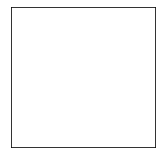

In [7]:
# Задаем размер рисунка
plt.figure(figsize=(15, 15))
for i in range(25):
    # Случайный индекс изображения
    start_index = random.randint(0, 10000)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    # Берем изображение на вход
    x_input = X_test[start_index:start_index+1]
    # Составляем предсказание
    prediction = labels_dict[np.argmax(model.predict(x_input))]
    # Получаем класс знака на самом деле
    actual = labels_dict[Y_test[start_index]]
    col = 'g' if prediction == actual else 'r'
    # Подписываем с определенным цветом текста в зависимости от правильности предсказания
    plt.xlabel(f'На деле: {actual}\nМодель: {prediction}', color=col)
    plt.imshow(X_test[start_index])
# Выводим рисунок и сохраняем
plt.show()
plt.savefig('../training_examples.png')